In [142]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy

from datetime import datetime
import statsmodels.formula.api as smf

# import pyreadr # read RDS file

from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.font_manager import FontProperties
from pylab import mpl

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None)

In [143]:
cross = pd.read_csv('/Users/liuwanting/Desktop/pythonhomework/TRD_Mnth202509.csv')
from pandas.tseries.offsets import MonthEnd
cross['month'] = pd.to_datetime(cross['Trdmnt'], format='%Y-%m') + MonthEnd(1)
cross['Stkcd'] = cross['Stkcd'].apply(lambda x: '{:0>6}'.format(x))
cross.rename(columns={'Mretwd': 'Return', 'Msmvosd': 'floatingvalue', 'Msmvttl': 'totalvalue'}, inplace=True)

rf_data = pd.read_csv('/Users/liuwanting/Desktop/pythonhomework/Marketret_mon_stock2024.csv')
rf_data['month'] = pd.to_datetime(rf_data['month'], format='%b %Y') + MonthEnd(1)
rf_data = rf_data[['month', 'rfmonth']]
cross = pd.merge(cross, rf_data, on='month', how='left')
cross['ret'] = cross['Return'] - cross['rfmonth']
cross['floatingvalue'] = cross['floatingvalue'] * 1000
cross['totalvalue'] = cross['totalvalue'] * 1000
cross

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,NaN
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,-0.128345
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,-0.119551
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,-0.137013
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,-0.417680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,NaN


In [144]:
# 生成下一个月的收益率
# 方法1：
all_months = pd.DataFrame(cross['month'].unique(), columns=['month'])
all_stocks = pd.DataFrame(cross['Stkcd'].unique(), columns=['Stkcd'])

full_index = all_stocks.merge(all_months, how='cross')
cross_full = full_index.merge(cross, on=['Stkcd', 'month'], how='left')
cross_full = cross_full.sort_values(['Stkcd', 'month'])
cross_full['next_ret_method1'] = cross_full.groupby('Stkcd')['ret'].shift(-1)
cross = cross.merge(cross_full[['Stkcd', 'month', 'next_ret_method1']],
                    on=['Stkcd', 'month'], how='left')

print("方法1完成：补全日期序列后使用shift")
cross[['Stkcd', 'month', 'ret', 'next_ret_method1']].head(20)

方法1完成：补全日期序列后使用shift


,Stkcd,month,ret,next_ret_method1
0,000001,1991-04-30,NaN,-0.128345
1,000001,1991-05-31,-0.128345,-0.119551
2,000001,1991-06-30,-0.119551,-0.137013
3,000001,1991-07-31,-0.137013,-0.417680
4,000001,1991-08-31,-0.417680,-0.039425
5,000001,1991-09-30,-0.039425,0.849080
6,000001,1991-10-31,0.849080,0.016213
7,000001,1991-11-30,0.016213,0.061181
8,000001,1991-12-31,0.061181,0.055237
9,000001,1992-01-31,0.055237,0.006749


In [145]:
# 方法2：截取个股收益率数据，日期加一个月，重命名后合并回去
from pandas.tseries.offsets import MonthEnd

# 创建下月收益率数据
next_ret_data = cross[['Stkcd', 'month', 'ret']].copy()

# 月份减少一个月
# 这样，当前行 (Stkcd, month, ret) 的 ret 列，会匹配到 month - 1 的记录上
next_ret_data['month'] = next_ret_data['month'] - MonthEnd(1)

# 重命名收益率列
next_ret_data.rename(columns={'ret': 'next_ret_method2'}, inplace=True)

# 合并回原数据 - 关键修正：使用 suffixes 处理 'next_ret_method2' 冲突
# 左侧（cross）重名列加 '_old'，右侧（next_ret_data）重名列加 '_new'
cross = cross.merge(
    next_ret_data,
    on=['Stkcd', 'month'],
    how='left',
    suffixes=('_old', '_new')
)

# 清理步骤：删除旧列并重命名新列
# 1. 删除旧版本的冲突列（如果存在）
if 'next_ret_method2_old' in cross.columns:
    cross.drop(columns=['next_ret_method2_old'], inplace=True)

# 2. 将新的结果列重命名回来
if 'next_ret_method2_new' in cross.columns:
    cross.rename(columns={'next_ret_method2_new': 'next_ret_method2'}, inplace=True)

print("方法2完成：日期加一个月后合并")

# 打印结果：确保只选择存在的列，避免 KeyError
required_cols = ['Stkcd', 'month', 'ret', 'next_ret_method1', 'next_ret_method2']
existing_cols = [col for col in required_cols if col in cross.columns]

print(cross[existing_cols].head(20))

方法2完成：日期加一个月后合并
     Stkcd      month       ret  next_ret_method1  next_ret_method2
0   000001 1991-04-30       NaN         -0.128345         -0.128345
1   000001 1991-05-31 -0.128345         -0.119551         -0.119551
2   000001 1991-06-30 -0.119551         -0.137013         -0.137013
3   000001 1991-07-31 -0.137013         -0.417680         -0.417680
4   000001 1991-08-31 -0.417680         -0.039425         -0.039425
5   000001 1991-09-30 -0.039425          0.849080          0.849080
6   000001 1991-10-31  0.849080          0.016213          0.016213
7   000001 1991-11-30  0.016213          0.061181          0.061181
8   000001 1991-12-31  0.061181          0.055237          0.055237
9   000001 1992-01-31  0.055237          0.006749          0.006749
10  000001 1992-02-29  0.006749          0.239957          0.239957
11  000001 1992-03-31  0.239957          0.471835          0.471835
12  000001 1992-04-30  0.471835          0.167934          0.167934
13  000001 1992-05-31  0.167934 

In [146]:
# 验证两种方法的结果是否一致
comparison = cross[['Stkcd', 'month', 'ret', 'next_ret_method1', 'next_ret_method2']].copy()
comparison['difference'] = comparison['next_ret_method1'] - comparison['next_ret_method2']

print("两种方法的差异统计：")
print(comparison['difference'].describe())
print(f"\n完全一致的记录数: {(comparison['difference'].abs() < 1e-10).sum()}")
print(f"总记录数: {len(comparison)}")

cross['next_ret'] = cross['next_ret_method2']
cross.drop(['next_ret_method1', 'next_ret_method2'], axis=1, inplace=True)

cross

两种方法的差异统计：
count    827102.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: difference, dtype: float64

完全一致的记录数: 827102
总记录数: 886913


,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,ret,next_ret
0,000001,1991-04,3,49.00,30,43.68,13400,6.150000e+05,1.157520e+09,2.118487e+09,20,NaN,NaN,4,1991-04-03,NaN,NaN,1991-04-30,0.006651,NaN,-0.128345
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,-0.128345,-0.119551
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,-0.119551,-0.137013
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,-0.137013,-0.417680
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,-0.417680,-0.039425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886908,920992,2025-05,6,20.00,30,20.46,92609592,1.922463e+09,5.707967e+08,1.979115e+09,19,0.051312,0.051715,64,2023-04-25,0.0,0.0,2025-05-31,NaN,NaN,NaN
886909,920992,2025-06,3,20.40,30,21.26,73152031,1.580767e+09,5.931152e+08,2.056500e+09,20,0.039101,0.039101,64,2023-04-25,0.0,0.0,2025-06-30,NaN,NaN,NaN
886910,920992,2025-07,1,21.13,31,22.44,96064221,2.126994e+09,6.260351e+08,2.170642e+09,23,0.055503,0.055503,64,2023-04-25,0.0,0.0,2025-07-31,NaN,NaN,NaN
886911,920992,2025-08,1,22.12,29,21.65,63953451,1.432608e+09,6.039955e+08,2.094225e+09,21,-0.035205,-0.035205,64,2023-04-25,0.0,0.0,2025-08-31,NaN,NaN,NaN


### 策略细节

In [147]:
fenweishu = pd.DataFrame(
    cross[cross['ret'].notna()].groupby(['month'])['ret'].quantile([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))
fenweishu

ret
month                   
1991-01-31 0.1 -0.002031
           0.2  0.002868
           0.3  0.006672
           0.4  0.010476
           0.5  0.022318
...                  ...
2024-12-31 0.5 -0.064220
           0.6 -0.041659
           0.7 -0.017765
           0.8  0.016086
           0.9  0.079173

[3672 rows x 1 columns]

In [148]:
fenweishu = fenweishu.reset_index()
fenweishu

,month,level_1,ret
0,1991-01-31,0.1,-0.002031
1,1991-01-31,0.2,0.002868
2,1991-01-31,0.3,0.006672
3,1991-01-31,0.4,0.010476
4,1991-01-31,0.5,0.022318
...,...,...,...
3667,2024-12-31,0.5,-0.064220
3668,2024-12-31,0.6,-0.041659
3669,2024-12-31,0.7,-0.017765
3670,2024-12-31,0.8,0.016086


In [149]:
fenweishu = fenweishu.pivot_table(index='month',columns='level_1',values='ret')
fenweishu

level_1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
month,,,,,,,,,
1991-01-31,-0.002031,0.002868,0.006672,0.010476,0.022318,0.034159,0.044819,0.055479,0.068586
1991-02-28,-0.042360,-0.037753,-0.012489,0.005470,0.019315,0.030097,0.034615,0.046888,0.081973
1991-03-31,-0.133314,-0.133261,-0.127661,-0.092379,-0.069798,-0.065144,-0.054707,-0.030694,0.028608
1991-04-30,-0.124371,-0.122867,-0.109328,-0.100079,-0.087628,-0.046745,0.020729,0.073833,0.090508
1991-05-31,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.132346,-0.099792,-0.078067,-0.059812,-0.044767,-0.028750,-0.012678,0.009087,0.051522
2024-09-30,0.121100,0.152297,0.172952,0.191662,0.210420,0.233569,0.262017,0.297110,0.367056
2024-10-31,-0.075368,-0.042757,-0.017695,0.006598,0.030677,0.057335,0.100766,0.170731,0.316122


In [150]:
fenweishu.columns = ['one','two','three','four','five','six','seven','eight','nine']
fenweishu

,one,two,three,four,five,six,seven,eight,nine
month,,,,,,,,,
1991-01-31,-0.002031,0.002868,0.006672,0.010476,0.022318,0.034159,0.044819,0.055479,0.068586
1991-02-28,-0.042360,-0.037753,-0.012489,0.005470,0.019315,0.030097,0.034615,0.046888,0.081973
1991-03-31,-0.133314,-0.133261,-0.127661,-0.092379,-0.069798,-0.065144,-0.054707,-0.030694,0.028608
1991-04-30,-0.124371,-0.122867,-0.109328,-0.100079,-0.087628,-0.046745,0.020729,0.073833,0.090508
1991-05-31,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.132346,-0.099792,-0.078067,-0.059812,-0.044767,-0.028750,-0.012678,0.009087,0.051522
2024-09-30,0.121100,0.152297,0.172952,0.191662,0.210420,0.233569,0.262017,0.297110,0.367056
2024-10-31,-0.075368,-0.042757,-0.017695,0.006598,0.030677,0.057335,0.100766,0.170731,0.316122


In [151]:
portfolio = pd.merge(cross,fenweishu,on='month',how='left')
portfolio = portfolio.dropna(subset=['ret','next_ret'])
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,ret,next_ret,one,two,three,four,five,six,seven,eight,nine
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,-0.128345,-0.119551,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,-0.119551,-0.137013,-0.309901,-0.119551,-0.115097,0.166237,0.177858,0.184748,0.190006,0.190283,0.201980
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,-0.137013,-0.417680,-0.244184,-0.128701,-0.086966,-0.052277,0.007620,0.067451,0.149691,0.216426,0.246553
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,-0.417680,-0.039425,-0.161430,-0.110028,-0.049934,-0.014296,0.018298,0.060859,0.219168,0.233226,0.238218
5,000001,1991-09,2,15.00,28,14.50,7240500,1.027070e+08,6.523394e+08,1.301399e+09,24,-0.033333,-0.033333,4,1991-08-01,NaN,NaN,1991-09-30,0.006092,-0.039425,0.849080,-0.118675,-0.067377,-0.053691,-0.041891,-0.030783,-0.018184,0.055164,0.175783,0.190067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886898,920992,2024-07,1,8.56,31,8.51,20489257,1.733678e+08,2.374135e+08,8.231802e+08,23,-0.010465,-0.010465,64,2023-04-25,0.0,0.0,2024-07-31,0.001184,-0.011649,-0.038721,-0.095137,-0.058535,-0.034114,-0.015179,0.001936,0.018424,0.036850,0.061316,0.111595
886899,920992,2024-08,1,8.50,30,8.19,14436632,1.185912e+08,2.284861e+08,7.922264e+08,22,-0.037603,-0.037603,64,2023-04-25,0.0,0.0,2024-08-31,0.001118,-0.038721,0.276049,-0.132346,-0.099792,-0.078067,-0.059812,-0.044767,-0.028750,-0.012678,0.009087,0.051522
886900,920992,2024-09,2,8.15,30,10.46,18109819,1.566140e+08,2.918149e+08,1.011806e+09,19,0.277167,0.277167,64,2023-04-25,0.0,0.0,2024-09-30,0.001118,0.276049,0.389895,0.121100,0.152297,0.172952,0.191662,0.210420,0.233569,0.262017,0.297110,0.367056
886901,920992,2024-10,8,13.02,31,14.55,86774237,1.145494e+09,4.059185e+08,1.407435e+09,18,0.391013,0.391013,64,2023-04-25,0.0,0.0,2024-10-31,0.001118,0.389895,0.241494,-0.075368,-0.042757,-0.017695,0.006598,0.030677,0.057335,0.100766,0.170731,0.316122


In [152]:
portfolio['sort'] = np.where(
    portfolio['ret'] <= portfolio['one'], 'P1',
    np.where(
        portfolio['ret'] <= portfolio['two'], 'P2',
        np.where(
            portfolio['ret'] <= portfolio['three'], 'P3',
            np.where(
                portfolio['ret'] <= portfolio['four'], 'P4',
                np.where(
                    portfolio['ret'] <= portfolio['five'], 'P5',
                    np.where(
                        portfolio['ret'] <= portfolio['six'], 'P6',
                        np.where(
                            portfolio['ret'] <= portfolio['seven'], 'P7',
                            np.where(
                                portfolio['ret'] <= portfolio['eight'], 'P8',
                                np.where(
                                    portfolio['ret'] <= portfolio['nine'],
                                    'P9', 'Pmax')))))))))
portfolio

,Stkcd,Trdmnt,Opndt,Mopnprc,Clsdt,Mclsprc,Mnshrtrd,Mnvaltrd,floatingvalue,totalvalue,Ndaytrd,Return,Mretnd,Markettype,Capchgdt,Ahshrtrd_M,Ahvaltrd_M,month,rfmonth,ret,next_ret,one,two,three,four,five,six,seven,eight,nine,sort
1,000001,1991-05,2,43.46,31,38.34,187800,7.675000e+06,1.016010e+09,1.859497e+09,24,-0.122253,0.235714,4,1991-04-03,NaN,NaN,1991-05-31,0.006092,-0.128345,-0.119551,-0.129118,-0.128345,-0.120582,-0.036993,-0.031989,-0.006657,0.055289,0.080639,0.202117,P2
2,000001,1991-06,1,38.53,28,33.99,30600,1.094000e+06,9.007350e+08,1.648521e+09,23,-0.113459,-0.113459,4,1991-04-03,NaN,NaN,1991-06-30,0.006092,-0.119551,-0.137013,-0.309901,-0.119551,-0.115097,0.166237,0.177858,0.184748,0.190006,0.190283,0.201980,P2
3,000001,1991-07,1,33.65,31,29.54,6100,1.940430e+05,7.828100e+08,1.432695e+09,16,-0.130921,-0.130921,4,1991-04-03,NaN,NaN,1991-07-31,0.006092,-0.137013,-0.417680,-0.244184,-0.128701,-0.086966,-0.052277,0.007620,0.067451,0.149691,0.216426,0.246553,P2
4,000001,1991-08,1,29.39,31,15.00,3243100,4.957624e+07,6.748338e+08,1.346275e+09,15,-0.411588,-0.411587,4,1991-08-01,NaN,NaN,1991-08-31,0.006092,-0.417680,-0.039425,-0.161430,-0.110028,-0.049934,-0.014296,0.018298,0.060859,0.219168,0.233226,0.238218,P1
5,000001,1991-09,2,15.00,28,14.50,7240500,1.027070e+08,6.523394e+08,1.301399e+09,24,-0.033333,-0.033333,4,1991-08-01,NaN,NaN,1991-09-30,0.006092,-0.039425,0.849080,-0.118675,-0.067377,-0.053691,-0.041891,-0.030783,-0.018184,0.055164,0.175783,0.190067,P5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886898,920992,2024-07,1,8.56,31,8.51,20489257,1.733678e+08,2.374135e+08,8.231802e+08,23,-0.010465,-0.010465,64,2023-04-25,0.0,0.0,2024-07-31,0.001184,-0.011649,-0.038721,-0.095137,-0.058535,-0.034114,-0.015179,0.001936,0.018424,0.036850,0.061316,0.111595,P5
886899,920992,2024-08,1,8.50,30,8.19,14436632,1.185912e+08,2.284861e+08,7.922264e+08,22,-0.037603,-0.037603,64,2023-04-25,0.0,0.0,2024-08-31,0.001118,-0.038721,0.276049,-0.132346,-0.099792,-0.078067,-0.059812,-0.044767,-0.028750,-0.012678,0.009087,0.051522,P6
886900,920992,2024-09,2,8.15,30,10.46,18109819,1.566140e+08,2.918149e+08,1.011806e+09,19,0.277167,0.277167,64,2023-04-25,0.0,0.0,2024-09-30,0.001118,0.276049,0.389895,0.121100,0.152297,0.172952,0.191662,0.210420,0.233569,0.262017,0.297110,0.367056,P8
886901,920992,2024-10,8,13.02,31,14.55,86774237,1.145494e+09,4.059185e+08,1.407435e+09,18,0.391013,0.391013,64,2023-04-25,0.0,0.0,2024-10-31,0.001118,0.389895,0.241494,-0.075368,-0.042757,-0.017695,0.006598,0.030677,0.057335,0.100766,0.170731,0.316122,Pmax


In [153]:
portfolio_mom =  pd.DataFrame(
    portfolio.groupby(['month','sort']).apply(lambda x: np.average(x['next_ret'],weights = x['floatingvalue']),include_groups=False))
portfolio_mom

0
month      sort          
1991-01-31 P1   -0.041567
           P2    0.010496
           P4    0.038284
           P6    0.081305
           P8    0.028134
...                   ...
2024-11-30 P6    0.013224
           P7   -0.014391
           P8   -0.039313
           P9   -0.063706
           Pmax -0.075116

[4066 rows x 1 columns]

In [154]:
portfolio_mom = portfolio_mom.reset_index()
portfolio_mom.columns = ['month', 'sort', 'p']
portfolio_mom

,month,sort,p
0,1991-01-31,P1,-0.041567
1,1991-01-31,P2,0.010496
2,1991-01-31,P4,0.038284
3,1991-01-31,P6,0.081305
4,1991-01-31,P8,0.028134
...,...,...,...
4061,2024-11-30,P6,0.013224
4062,2024-11-30,P7,-0.014391
4063,2024-11-30,P8,-0.039313
4064,2024-11-30,P9,-0.063706


In [155]:
# Month plus one month
portfolio_mom['month'] = portfolio_mom['month'] + MonthEnd(1)
# drop NA
portfolio_mom = portfolio_mom.dropna()
portfolio_mom

,month,sort,p
0,1991-02-28,P1,-0.041567
1,1991-02-28,P2,0.010496
2,1991-02-28,P4,0.038284
3,1991-02-28,P6,0.081305
4,1991-02-28,P8,0.028134
...,...,...,...
4061,2024-12-31,P6,0.013224
4062,2024-12-31,P7,-0.014391
4063,2024-12-31,P8,-0.039313
4064,2024-12-31,P9,-0.063706


In [156]:
portfolio_mom = portfolio_mom.pivot_table(index='month',
                                                    columns='sort',
                                                    values='p')
# long lowest return stocks and short highest return stocks
portfolio_mom['My_portfolio'] = portfolio_mom['P1'] - portfolio_mom['Pmax']
portfolio_mom

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1991-02-28,-0.041567,0.010496,NaN,0.038284,NaN,0.081305,NaN,0.028134,NaN,-0.002070,-0.039497
1991-03-31,-0.133253,-0.069140,-0.133293,0.023904,-0.125264,0.070941,-0.133504,-0.044343,-0.070455,-0.059149,-0.074104
1991-04-30,-0.122736,-0.123391,-0.103582,-0.077512,-0.133193,-0.000595,0.070484,-0.097744,0.120035,0.087227,-0.209963
1991-05-31,-0.006657,-0.129118,-0.036993,-0.120582,-0.130814,-0.031989,0.080639,0.055289,0.202117,0.238572,-0.245229
1991-06-30,-0.093032,-0.119551,-0.460637,-0.309901,0.190006,0.177858,0.213185,0.190283,0.166237,0.201980,-0.295012
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.045370,-0.039031,-0.039789,-0.014291,-0.037746,-0.032279,-0.039920,-0.022724,-0.027649,-0.073343,0.027973
2024-09-30,0.270886,0.256217,0.229362,0.215553,0.222274,0.208572,0.158399,0.196238,0.151909,0.187023,0.083862
2024-10-31,-0.039394,-0.003047,-0.003911,0.012068,-0.025691,0.003557,0.021287,0.038553,-0.006242,0.092651,-0.132045


In [157]:
portfolio_mom = portfolio_mom['1995-01':'2024-12']
portfolio_mom

sort,P1,P2,P3,P4,P5,P6,P7,P8,P9,Pmax,My_portfolio
month,,,,,,,,,,,
1995-01-31,-0.099504,-0.143138,-0.126409,-0.139308,-0.085355,-0.118229,-0.134357,-0.109772,-0.123795,-0.171014,0.071510
1995-02-28,0.001391,-0.033748,-0.033355,-0.049007,-0.031232,-0.023535,-0.021406,-0.010941,-0.020619,-0.022268,0.023659
1995-03-31,0.158266,0.169769,0.176323,0.136581,0.124047,0.075794,0.034796,0.121338,0.113594,0.073868,0.084398
1995-04-30,-0.107116,-0.106273,-0.117236,-0.090589,-0.122070,-0.125683,-0.128063,-0.108056,-0.107713,-0.110107,0.002991
1995-05-31,0.088567,0.190955,0.169538,0.144034,0.209618,0.134673,0.125142,0.188867,0.172653,0.186937,-0.098370
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.045370,-0.039031,-0.039789,-0.014291,-0.037746,-0.032279,-0.039920,-0.022724,-0.027649,-0.073343,0.027973
2024-09-30,0.270886,0.256217,0.229362,0.215553,0.222274,0.208572,0.158399,0.196238,0.151909,0.187023,0.083862
2024-10-31,-0.039394,-0.003047,-0.003911,0.012068,-0.025691,0.003557,0.021287,0.038553,-0.006242,0.092651,-0.132045


In [158]:
model_port = smf.ols('My_portfolio ~ 1',
                 data=portfolio_mom['2000-02':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 11 Nov 2025   Prob (F-statistic):                nan
Time:                        13:46:10   Log-Likelihood:                 381.72
No. Observations:                 299   AIC:                            -761.4
Df Residuals:                     298   BIC:                            -757.7
Df Model:                           0                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0077      0.004      2.013      0.0

In [159]:
from pandas.tseries.offsets import MonthEnd # 月末
Market_ret = pd.read_csv('/Users/liuwanting/Desktop/pythonhomework/Marketret_mon_stock2024.csv')
Market_ret['month'] = pd.to_datetime(Market_ret['month'], format='%b %Y') + MonthEnd(0)
Market_ret.set_index('month', inplace=True)
Market_ret.sort_index(inplace=True)
Market_ret = Market_ret.drop(columns=['Unnamed: 0'])
Market_ret.rename(columns={'ret': 'MKT'}, inplace=True)
Market_ret

,MarketR,MarketR_e,rfmonth,MKT,ret_e,marketret3,marketret6,marketret12,Q
month,,,,,,,,,
1991-01-31,0.029998,0.036554,0.006930,0.023068,0.029624,-0.084127,-0.305662,0.254049,1991 Q1
1991-02-28,0.010203,0.021860,0.006930,0.003273,0.014930,-0.183573,-0.384745,0.241492,1991 Q1
1991-03-31,-0.099663,-0.060425,0.006930,-0.106593,-0.067355,-0.252928,-0.445049,0.288857,1991 Q1
1991-04-30,-0.079652,-0.031449,0.006651,-0.086303,-0.038100,-0.234776,-0.394937,0.691749,1991 Q2
1991-05-31,-0.074521,0.005375,0.006092,-0.080613,-0.000717,-0.236294,0.181673,1.542701,1991 Q2
...,...,...,...,...,...,...,...,...,...
2024-08-31,-0.031468,-0.033685,0.001118,-0.032586,-0.034803,0.151050,NaN,NaN,2024 Q3
2024-09-30,0.195992,0.227078,0.001118,0.194874,0.225960,0.200147,NaN,NaN,2024 Q3
2024-10-31,-0.003409,0.070220,0.001118,-0.004527,0.069102,0.000228,NaN,NaN,2024 Q4


In [160]:
MYPOR = portfolio_mom[['P1','Pmax','My_portfolio']]
MYPOR = MYPOR.dropna()
MYPOR = pd.merge(MYPOR,Market_ret[['MKT']],left_index=True,right_index=True,how='left')
MYPOR['month'] = pd.date_range(start = '1995',periods=len(MYPOR),freq = 'ME')
MYPOR.set_index('month', inplace = True)
MYPOR = MYPOR["2000":]
MYPOR

,P1,Pmax,My_portfolio,MKT
month,,,,
2000-01-31,0.126771,0.285285,-0.158515,0.158982
2000-02-29,0.123699,0.125865,-0.002165,0.120168
2000-03-31,0.038587,-0.041766,0.080353,0.054070
2000-04-30,-0.003899,-0.010539,0.006641,0.011158
2000-05-31,0.025069,0.037238,-0.012170,0.025835
...,...,...,...,...
2024-08-31,-0.045370,-0.073343,0.027973,-0.032586
2024-09-30,0.270886,0.187023,0.083862,0.194874
2024-10-31,-0.039394,0.092651,-0.132045,-0.004527


In [161]:
model_port = smf.ols('My_portfolio ~ MKT',
                 data=MYPOR['2000-02':'2024-12']).fit(
                     cov_type='HAC', cov_kwds={'maxlags': 6})
print(model_port.summary())

                            OLS Regression Results                            
Dep. Variable:           My_portfolio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.02524
Date:                Tue, 11 Nov 2025   Prob (F-statistic):              0.874
Time:                        13:46:10   Log-Likelihood:                 381.75
No. Observations:                 299   AIC:                            -759.5
Df Residuals:                     297   BIC:                            -752.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0077      0.004      2.084      0.0

### 结果

In [162]:
# 计算投资组合的Sharpe Ratio
sharpe_ratio = MYPOR['My_portfolio'].mean() / MYPOR['My_portfolio'].std() * np.sqrt(12)
print(f"Sharpe Ratio: {sharpe_ratio}")

Sharpe Ratio: 0.361895552678127


In [163]:
# 还原投资策略的价格
MYPOR_pic = MYPOR['2000-01':'2024-12'].copy()
MYPOR_pic['price_portfolio'] = (1 + MYPOR_pic['My_portfolio']).cumprod()
MYPOR_pic['price_p1'] = (1 + MYPOR_pic['P1']).cumprod()
MYPOR_pic['price_pmax'] = (1 + MYPOR_pic['Pmax']).cumprod()
MYPOR_pic['price_market'] = (1 + MYPOR_pic['MKT']).cumprod()
MYPOR_pic

,P1,Pmax,My_portfolio,MKT,price_portfolio,price_p1,price_pmax,price_market
month,,,,,,,,
2000-01-31,0.126771,0.285285,-0.158515,0.158982,0.841485,1.126771,1.285285,1.158982
2000-02-29,0.123699,0.125865,-0.002165,0.120168,0.839663,1.266151,1.447057,1.298255
2000-03-31,0.038587,-0.041766,0.080353,0.054070,0.907133,1.315008,1.386619,1.368451
2000-04-30,-0.003899,-0.010539,0.006641,0.011158,0.913156,1.309881,1.372005,1.383720
2000-05-31,0.025069,0.037238,-0.012170,0.025835,0.902044,1.342718,1.423097,1.419469
...,...,...,...,...,...,...,...,...
2024-08-31,-0.045370,-0.073343,0.027973,-0.032586,3.884593,3.282065,0.384855,2.612189
2024-09-30,0.270886,0.187023,0.083862,0.194874,4.210363,4.171129,0.456831,3.121237
2024-10-31,-0.039394,0.092651,-0.132045,-0.004527,3.654406,4.006810,0.499157,3.107107


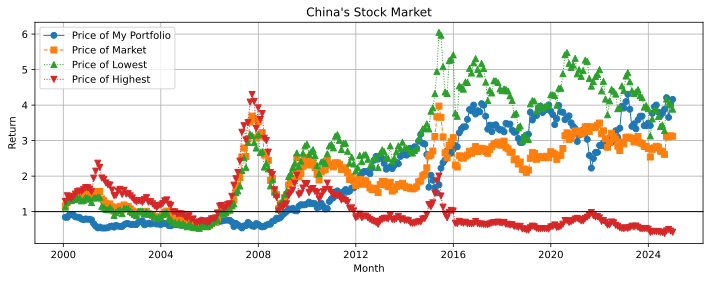

In [164]:
# 画图
fig = plt.figure(figsize=(12, 4))
plt.plot(
    'price_portfolio',
    'o-',
    label='Price of My Portfolio',
    linewidth=1,
    data=MYPOR_pic)
plt.title("China's Stock Market")
plt.xlabel('Month')
plt.ylabel('Return')

plt.plot(
    'price_market',
    's--',
    label='Price of Market',
    linewidth=1,
    data=MYPOR_pic)

plt.plot(
    'price_p1',
    '^:',
    label='Price of Lowest',
    linewidth=1,
    data=MYPOR_pic)

plt.plot(
    'price_pmax',
    'v:',
    label='Price of Highest',
    linewidth=1,
    data=MYPOR_pic)

# plot legend
plt.legend(loc='upper left')

# 添加网格线
plt.grid(True)

# 添加横线 1
plt.axhline(y=1, color='black', linewidth=1)

plt.show();

In [165]:
# 计算累积收益率
MYPOR['cumulative_return'] = (1 + MYPOR['My_portfolio']).cumprod()

# 计算滚动最大值
MYPOR['rolling_max'] = MYPOR['cumulative_return'].cummax()

# 计算回撤
MYPOR['drawdown'] = MYPOR['cumulative_return'] / MYPOR['rolling_max'] - 1

# 计算最大回撤
max_drawdown = MYPOR['drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: -0.5192818427532462


In [166]:
# 找出最大回撤的时间
max_drawdown_end = MYPOR['drawdown'].idxmin() # 返回 Series 中最小值的索引
max_drawdown_start = MYPOR.loc[:max_drawdown_end, 'cumulative_return'].idxmax() # 这部分代码选择了从数据开始到 max_drawdown_end 时间点之间的所有累积收益率

print(f"Maximum Drawdown: {max_drawdown}")
print(f"Maximum Drawdown Start Date: {max_drawdown_start}")
print(f"Maximum Drawdown End Date: {max_drawdown_end}")

Maximum Drawdown: -0.5192818427532462
Maximum Drawdown Start Date: 2014-08-31 00:00:00
Maximum Drawdown End Date: 2015-04-30 00:00:00


### 投资策略评估指标体系

In [167]:
# 构建完整的策略评估函数
def calculate_strategy_metrics(returns, benchmark_returns=None, rf_rate=0.03/12):
    """
    计算投资策略的全面评估指标

    Parameters:
    -----------
    returns : pd.Series
        策略收益率序列（月度）
    benchmark_returns : pd.Series, optional
        基准收益率序列（用于计算Information Ratio）
    rf_rate : float
        月度无风险利率，默认年化3%

    Returns:
    --------
    dict : 包含所有评估指标的字典
    """

    metrics = {}

    # 1. 收益指标
    # 累积收益率
    cumulative_return = (1 + returns).prod() - 1
    metrics['累积收益率 (Cumulative Return)'] = f"{cumulative_return:.2%}"

    # 年化收益率
    n_months = len(returns)
    n_years = n_months / 12
    annualized_return = (1 + cumulative_return) ** (1/n_years) - 1
    metrics['年化收益率 (Annualized Return)'] = f"{annualized_return:.2%}"

    # 月平均收益率
    avg_monthly_return = returns.mean()
    metrics['月平均收益率 (Average Monthly Return)'] = f"{avg_monthly_return:.2%}"

    # 2. 风险指标
    # 收益率标准差
    volatility = returns.std()
    metrics['月度波动率 (Monthly Volatility)'] = f"{volatility:.2%}"

    # 年化波动率
    annualized_volatility = volatility * np.sqrt(12)
    metrics['年化波动率 (Annualized Volatility)'] = f"{annualized_volatility:.2%}"

    # 最大回撤
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = cumulative / running_max - 1
    max_drawdown = drawdown.min()
    metrics['最大回撤 (Maximum Drawdown)'] = f"{max_drawdown:.2%}"

    # 下行风险（只考虑负收益的标准差）
    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std()
    metrics['下行标准差 (Downside Deviation)'] = f"{downside_deviation:.2%}"

    # VaR (5% 分位数)
    var_95 = returns.quantile(0.05)
    metrics['VaR (95%)'] = f"{var_95:.2%}"

    # CVaR (条件VaR, 最差5%的平均值)
    cvar_95 = returns[returns <= var_95].mean()
    metrics['CVaR (95%)'] = f"{cvar_95:.2%}"

    # 3. 风险调整收益指标
    # 夏普比率
    excess_returns = returns - rf_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(12)
    metrics['夏普比率 (Sharpe Ratio)'] = f"{sharpe_ratio:.4f}"

    # 索提诺比率（使用下行风险）
    if downside_deviation > 0:
        sortino_ratio = excess_returns.mean() / downside_deviation * np.sqrt(12)
        metrics['索提诺比率 (Sortino Ratio)'] = f"{sortino_ratio:.4f}"
    else:
        metrics['索提诺比率 (Sortino Ratio)'] = "N/A"

    # 卡玛比率（年化收益率/最大回撤）
    if max_drawdown < 0:
        calmar_ratio = annualized_return / abs(max_drawdown)
        metrics['卡玛比率 (Calmar Ratio)'] = f"{calmar_ratio:.4f}"
    else:
        metrics['卡玛比率 (Calmar Ratio)'] = "N/A"

    # 信息比率（如果提供了基准）
    if benchmark_returns is not None:
        active_returns = returns - benchmark_returns
        tracking_error = active_returns.std()
        if tracking_error > 0:
            information_ratio = active_returns.mean() / tracking_error * np.sqrt(12)
            metrics['信息比率 (Information Ratio)'] = f"{information_ratio:.4f}"
            metrics['跟踪误差 (Tracking Error)'] = f"{tracking_error * np.sqrt(12):.2%}"
        else:
            metrics['信息比率 (Information Ratio)'] = "N/A"
            metrics['跟踪误差 (Tracking Error)'] = "N/A"

    # 4. 其他重要指标
    # 胜率
    win_rate = (returns > 0).sum() / len(returns)
    metrics['胜率 (Win Rate)'] = f"{win_rate:.2%}"

    # 盈亏比
    avg_gain = returns[returns > 0].mean()
    avg_loss = abs(returns[returns < 0].mean())
    if avg_loss > 0:
        profit_loss_ratio = avg_gain / avg_loss
        metrics['盈亏比 (Profit/Loss Ratio)'] = f"{profit_loss_ratio:.4f}"
    else:
        metrics['盈亏比 (Profit/Loss Ratio)'] = "N/A"

    # 最长回撤期
    # 找到所有创新高的时间点
    is_new_high = cumulative == running_max
    new_high_dates = cumulative[is_new_high].index

    # 计算每次创新高之间的间隔
    if len(new_high_dates) > 1:
        max_drawdown_duration = 0
        for i in range(len(new_high_dates) - 1):
            duration = (new_high_dates[i+1] - new_high_dates[i]).days / 30  # 转换为月
            max_drawdown_duration = max(max_drawdown_duration, duration)
        metrics['最长回撤期 (月) (Max Drawdown Duration)'] = f"{max_drawdown_duration:.1f}"
    else:
        metrics['最长回撤期 (月) (Max Drawdown Duration)'] = "N/A"

    # 最大回撤起止时间
    max_dd_end = drawdown.idxmin()
    max_dd_start = cumulative.loc[:max_dd_end].idxmax()
    metrics['最大回撤开始时间'] = max_dd_start.strftime('%Y-%m')
    metrics['最大回撤结束时间'] = max_dd_end.strftime('%Y-%m')

    return metrics

# 使用示例
print("=" * 80)
print("投资组合策略评估指标")
print("=" * 80)
portfolio_metrics = calculate_strategy_metrics(
    MYPOR['My_portfolio'],
    benchmark_returns=MYPOR['MKT'],
    rf_rate=0.03/12  # 假设年化无风险利率为3%
)

for key, value in portfolio_metrics.items():
    print(f"{key:.<50} {value:>20}")
print("=" * 80)

投资组合策略评估指标
累积收益率 (Cumulative Return).........................              316.14%
年化收益率 (Annualized Return).........................                5.87%
月平均收益率 (Average Monthly Return)...................                0.71%
月度波动率 (Monthly Volatility)........................                6.82%
年化波动率 (Annualized Volatility).....................               23.62%
最大回撤 (Maximum Drawdown)...........................              -51.93%
下行标准差 (Downside Deviation)........................                4.79%
VaR (95%).........................................               -9.92%
CVaR (95%)........................................              -14.76%
夏普比率 (Sharpe Ratio)...............................               0.2349
索提诺比率 (Sortino Ratio).............................               0.3346
卡玛比率 (Calmar Ratio)...............................               0.1130
信息比率 (Information Ratio)..........................               0.0149
跟踪误差 (Tracking Error).............................   

In [168]:
# 对比分析：我的策略 vs 市场 vs P1 vs Pmax
print("\n" + "=" * 80)
print("不同投资组合的对比分析")
print("=" * 80)

strategies = {
    '反转策略 (My Portfolio)': MYPOR['My_portfolio'],
    '市场组合 (Market)': MYPOR['MKT'],
    '最低收益组 (P1)': MYPOR['P1'],
    '最高收益组 (Pmax)': MYPOR['Pmax']
}

comparison_results = []

for name, returns in strategies.items():
    print(f"\n【{name}】")
    print("-" * 80)
    metrics = calculate_strategy_metrics(returns, benchmark_returns=MYPOR['MKT'], rf_rate=0.03/12)

    # 只显示关键指标
    key_metrics = [
        '累积收益率 (Cumulative Return)',
        '年化收益率 (Annualized Return)',
        '年化波动率 (Annualized Volatility)',
        '最大回撤 (Maximum Drawdown)',
        '夏普比率 (Sharpe Ratio)',
        '索提诺比率 (Sortino Ratio)',
        '卡玛比率 (Calmar Ratio)',
        '胜率 (Win Rate)'
    ]

    for key in key_metrics:
        if key in metrics:
            print(f"{key:.<50} {metrics[key]:>20}")

    # 保存用于后续对比
    comparison_results.append({
        '策略': name,
        '年化收益': metrics['年化收益率 (Annualized Return)'],
        '年化波动': metrics['年化波动率 (Annualized Volatility)'],
        '夏普比率': metrics['夏普比率 (Sharpe Ratio)'],
        '最大回撤': metrics['最大回撤 (Maximum Drawdown)']
    })

print("\n" + "=" * 80)


不同投资组合的对比分析

【反转策略 (My Portfolio)】
--------------------------------------------------------------------------------
累积收益率 (Cumulative Return).........................              316.14%
年化收益率 (Annualized Return).........................                5.87%
年化波动率 (Annualized Volatility).....................               23.62%
最大回撤 (Maximum Drawdown)...........................              -51.93%
夏普比率 (Sharpe Ratio)...............................               0.2349
索提诺比率 (Sortino Ratio).............................               0.3346
卡玛比率 (Calmar Ratio)...............................               0.1130
胜率 (Win Rate).....................................               53.67%

【市场组合 (Market)】
--------------------------------------------------------------------------------
累积收益率 (Cumulative Return).........................              212.19%
年化收益率 (Annualized Return).........................                4.66%
年化波动率 (Annualized Volatility).....................               

In [169]:
# 创建对比表格
comparison_df = pd.DataFrame(comparison_results)
print("\n策略对比汇总表:")
print(comparison_df.to_string(index=False))
print("\n")


策略对比汇总表:
                 策略   年化收益   年化波动    夏普比率    最大回撤
反转策略 (My Portfolio)  5.87% 23.62%  0.2349 -51.93%
      市场组合 (Market)  4.66% 26.24%  0.1910 -70.74%
         最低收益组 (P1)  5.58% 31.20%  0.2318 -66.59%
       最高收益组 (Pmax) -3.41% 31.94% -0.0412 -91.05%




### 回撤分析

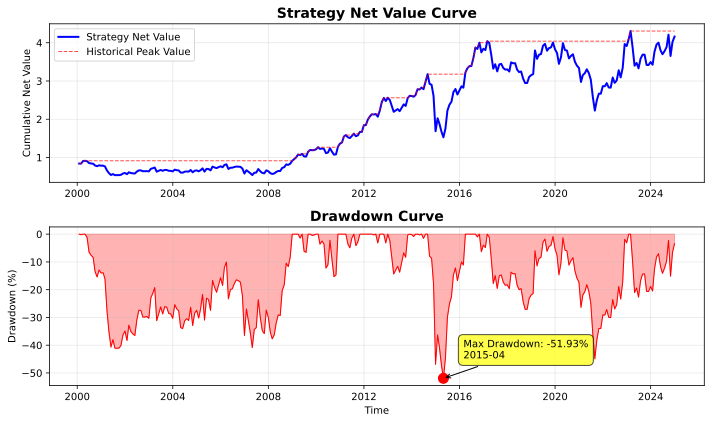

In [170]:
# 绘制完整的回撤图
cumulative_return = (1 + MYPOR['My_portfolio']).cumprod()
running_max = cumulative_return.cummax()
drawdown = (cumulative_return / running_max - 1) * 100  # 转换为百分比

fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# 累积收益率和最大值
axes[0].plot(cumulative_return.index, cumulative_return, 'b-', label='Strategy Net Value', linewidth=2)
axes[0].plot(running_max.index, running_max, 'r--', label='Historical Peak Value', linewidth=1, alpha=0.7)
axes[0].set_title('Strategy Net Value Curve', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cumulative Net Value')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 回撤曲线
axes[1].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
axes[1].plot(drawdown.index, drawdown, 'r-', linewidth=1)
axes[1].set_title('Drawdown Curve', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)')
axes[1].set_xlabel('Time')
axes[1].grid(True, alpha=0.3)

# 标注最大回撤点
max_dd_value = drawdown.min()
max_dd_date = drawdown.idxmin()
axes[1].plot(max_dd_date, max_dd_value, 'ro', markersize=10)
axes[1].annotate(f'Max Drawdown: {max_dd_value:.2f}%\n{max_dd_date.strftime("%Y-%m")}',
                xy=(max_dd_date, max_dd_value),
                xytext=(20, 20), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
plt.tight_layout();
plt.show();

### 年度季度表现

Annual Returns (%):
       Reversal Strategy  Market  Lowest Return Group  Highest Return Group
month                                                                      
2000              -21.47   53.24                37.89                 67.39
2001              -24.32  -25.73               -23.81                 -3.83
2002                7.05  -20.56               -15.84                -20.71
2003               -0.01   -4.89                -5.91                 -7.01
2004                4.13  -17.90               -25.85                -28.61
2005               16.20  -11.89                 0.77                -14.94
2006              -24.68  113.02                96.11                142.35
2007               10.28  166.61               160.12                124.64
2008               42.76  -65.06               -58.76                -71.73
2009               33.31  104.97               121.50                 61.01
2010               12.01   -8.65                -0.03               

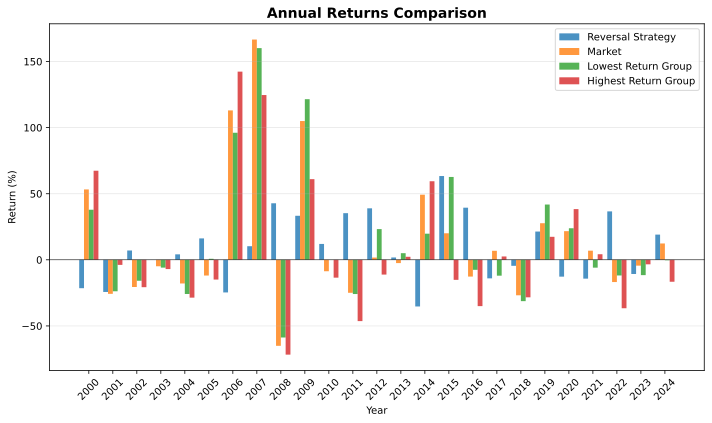

In [171]:
# 年度表现
annual_returns = MYPOR.groupby(MYPOR.index.year).agg({
    'My_portfolio': lambda x: (1 + x).prod() - 1,
    'MKT': lambda x: (1 + x).prod() - 1,
    'P1': lambda x: (1 + x).prod() - 1,
    'Pmax': lambda x: (1 + x).prod() - 1
})

annual_returns.columns = ['Reversal Strategy', 'Market', 'Lowest Return Group', 'Highest Return Group']
annual_returns = annual_returns * 100  # Convert to percentage

print("Annual Returns (%):")
print(annual_returns.round(2))
print(f"\nAverage Annual Return (%): {annual_returns['Reversal Strategy'].mean():.2f}")
print(f"Annual Return Std Dev (%): {annual_returns['Reversal Strategy'].std():.2f}")
print(f"Positive Return Years: {(annual_returns['Reversal Strategy'] > 0).sum()}/{len(annual_returns)}")

# Plot annual returns comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(annual_returns))
width = 0.2

bars1 = ax.bar(x - 1.5*width, annual_returns['Reversal Strategy'], width, label='Reversal Strategy', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, annual_returns['Market'], width, label='Market', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, annual_returns['Lowest Return Group'], width, label='Lowest Return Group', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, annual_returns['Highest Return Group'], width, label='Highest Return Group', alpha=0.8)

ax.set_xlabel('Year')
ax.set_ylabel('Return (%)')
ax.set_title('Annual Returns Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(annual_returns.index, rotation=45)
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show();


Quarterly Returns (%):
         Q1     Q2     Q3     Q4  Annual
Year                                    
2000  -9.29  -5.89  -7.48  -0.58  -21.47
2001 -15.94 -14.23  -4.96  10.46  -24.32
2002  -0.18   6.26   1.60  -0.66    7.05
2003  15.88  -8.61  -0.11  -5.48   -0.01
2004   3.92  -5.09   7.17  -1.49    4.13
2005   7.90  -2.32   5.87   4.14   16.20
2006   6.74 -10.72   3.62 -23.72  -24.68
2007   1.57   2.81  -1.52   7.24   10.28
2008  -8.99  10.90  26.68  11.66   42.76
2009  18.09  -4.72  16.39   1.80   33.31
2010   1.63  -8.76  -4.82  26.91   12.01
2011  16.28  -1.47   1.01  16.89   35.28
2012  12.35   3.04  14.64   4.70   38.95
2013 -14.35   0.74   6.22  11.02    1.76
2014   6.80   0.04   5.06 -42.36  -35.29
2015  -0.62  32.69  21.83   1.70   63.38
2016  16.83   5.27  13.21   0.14   39.43
2017   3.96 -13.96   0.28  -4.16  -14.03
2018   4.80  -6.64  -8.84   7.02   -4.54
2019  13.49   9.54  -1.54  -0.84   21.39
2020  -5.45   4.91  -2.61  -9.67  -12.73
2021  -4.12  -5.22 -17.77  14.76 

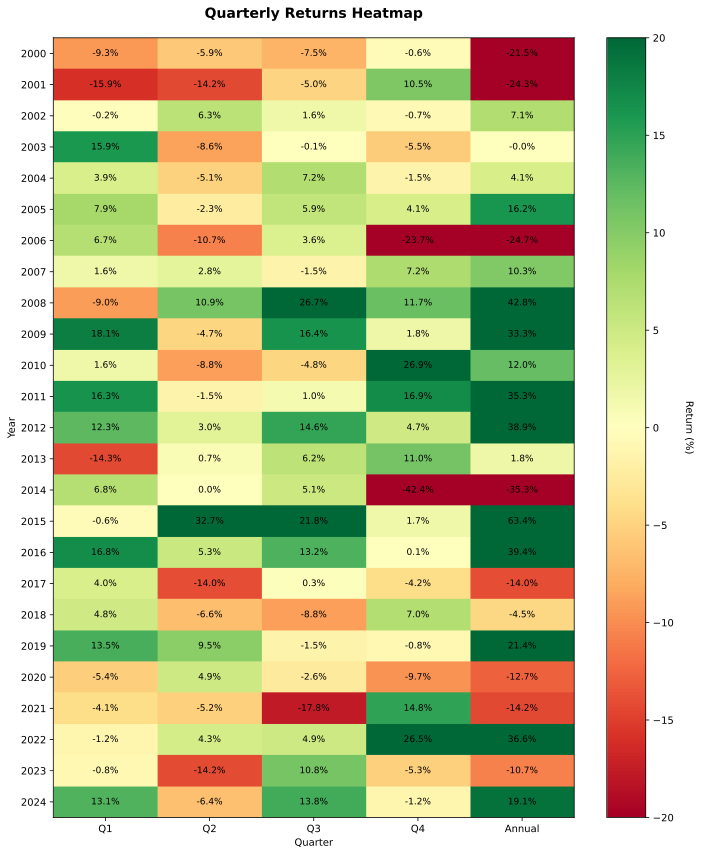

In [172]:
# 季度表现热力图
MYPOR_copy = MYPOR.copy()
MYPOR_copy['Year'] = MYPOR_copy.index.year
MYPOR_copy['Quarter'] = MYPOR_copy.index.quarter

quarterly_returns = MYPOR_copy.groupby(['Year', 'Quarter'])['My_portfolio'].apply(
    lambda x: (1 + x).prod() - 1
) * 100

# 转换为透视表
quarterly_pivot = quarterly_returns.reset_index().pivot(index='Year', columns='Quarter', values='My_portfolio')
quarterly_pivot.columns = ['Q1', 'Q2', 'Q3', 'Q4']

# 添加年度收益率列
quarterly_pivot['Annual'] = annual_returns['Reversal Strategy']

print("\nQuarterly Returns (%):")
print(quarterly_pivot.round(2))

# 绘制热力图
fig, ax = plt.subplots(figsize=(10, 12))
im = ax.imshow(quarterly_pivot.values, cmap='RdYlGn', aspect='auto', vmin=-20, vmax=20)

# 设置坐标轴
ax.set_xticks(np.arange(len(quarterly_pivot.columns)))
ax.set_yticks(np.arange(len(quarterly_pivot.index)))
ax.set_xticklabels(quarterly_pivot.columns)
ax.set_yticklabels(quarterly_pivot.index)

# 在每个格子中显示数值
for i in range(len(quarterly_pivot.index)):
    for j in range(len(quarterly_pivot.columns)):
        value = quarterly_pivot.values[i, j]
        if not np.isnan(value):
            text = ax.text(j, i, f'{value:.1f}%',
                         ha="center", va="center", color="black", fontsize=9)

ax.set_title('Quarterly Returns Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Quarter')
ax.set_ylabel('Year')

# 添加颜色条
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Return (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show();